<a href="https://colab.research.google.com/github/kridtapon/Connors-Williams-Reversal/blob/main/Connors_Williams_Reversal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.3 MB/s eta 0:00:00


In [1]:
pip install --upgrade yfinance

In [9]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate Connors RSI (CRSI)
def calculate_connors_rsi(df, rsi_period=3, roc_period=2, ma_period=3):
    """
    Calculate Connors RSI (CRSI).
    """
    delta = df['Close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain, index=df.index).rolling(window=rsi_period, min_periods=1).mean()
    avg_loss = pd.Series(loss, index=df.index).rolling(window=rsi_period, min_periods=1).mean().replace(0, np.nan)

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    rsi = rsi.fillna(50)  # Filling NaN with 50, a neutral RSI value

    roc = df['Close'].pct_change(roc_period) * 100

    ma_rsi = rsi.rolling(window=ma_period, min_periods=1).mean()
    ma_roc = roc.rolling(window=ma_period, min_periods=1).mean()

    crsi = (rsi + roc + ma_rsi + ma_roc) / 4  # Averaging instead of summing
    return crsi

# Function to calculate Williams Percent Range (WPR)
def calculate_wpr(df, period=14):
    """
    Calculate Williams Percent Range (WPR).
    """
    high_rolling = df['High'].rolling(window=period).max()
    low_rolling = df['Low'].rolling(window=period).min()

    wpr = -100 * (high_rolling - df['Close']) / (high_rolling - low_rolling)
    return wpr

# Define the stock symbol and time period
symbol = 'RL'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate Connors RSI (CRSI) and Williams Percent Range (WPR)
df['CRSI'] = calculate_connors_rsi(df, rsi_period=3, roc_period=2, ma_period=3)
df['WPR'] = calculate_wpr(df, period=14)

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Define Entry and Exit signals based on CRSI and WPR
df['Entry'] = (df['CRSI'] > df['CRSI'].shift(10)) & (df['WPR'] < -80)
df['Exit'] = (df['CRSI'] < df['CRSI'].shift(10)) & (df['WPR'] > -20)

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001,
    freq='D'
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed


Start                                2020-01-02 00:00:00
End                                  2024-12-31 00:00:00
Period                                1258 days 00:00:00
Start Value                                     100000.0
End Value                                  214018.946176
Total Return [%]                              114.018946
Benchmark Return [%]                          114.566604
Max Gross Exposure [%]                             100.0
Total Fees Paid                              3849.758471
Max Drawdown [%]                               32.128857
Max Drawdown Duration                  176 days 00:00:00
Total Trades                                          13
Total Closed Trades                                   13
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   84.615385
Best Trade [%]                                 23.264019
Worst Trade [%]                

In [5]:
# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,214566.603854
Total Return [%],114.566604
Benchmark Return [%],114.566604
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],50.197837


[*********************100%***********************]  1 of 1 completed


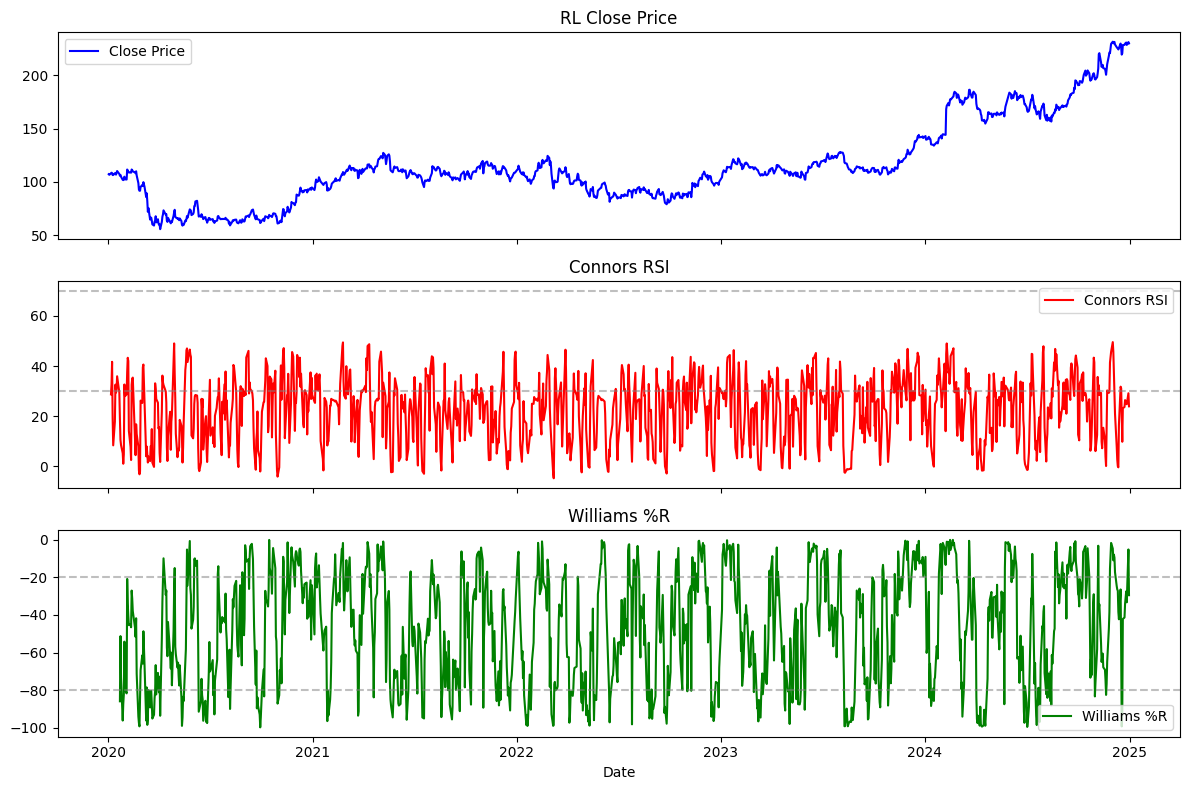

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

def calculate_connors_rsi(df, rsi_period=3, roc_period=2, ma_period=3):
    """
    Calculate Connors RSI (CRSI).
    """
    delta = df['Close'].diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    avg_gain = pd.Series(gain, index=df.index).rolling(window=rsi_period, min_periods=1).mean()
    avg_loss = pd.Series(loss, index=df.index).rolling(window=rsi_period, min_periods=1).mean().replace(0, np.nan)

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    rsi = rsi.fillna(50)  # Filling NaN with 50, a neutral RSI value

    roc = df['Close'].pct_change(roc_period) * 100

    ma_rsi = rsi.rolling(window=ma_period, min_periods=1).mean()
    ma_roc = roc.rolling(window=ma_period, min_periods=1).mean()

    crsi = (rsi + roc + ma_rsi + ma_roc) / 4  # Averaging instead of summing
    return crsi

def calculate_wpr(df, period=14):
    """
    Calculate Williams Percent Range (WPR).
    """
    high_rolling = df['High'].rolling(window=period).max()
    low_rolling = df['Low'].rolling(window=period).min()

    wpr = -100 * (high_rolling - df['Close']) / (high_rolling - low_rolling)
    return wpr

# Define the stock symbol and time period
symbol = 'RL'
start_date = '2020-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate indicators
df['CRSI'] = calculate_connors_rsi(df)
df['WPR'] = calculate_wpr(df)

# Plot the close price, CRSI, and WPR
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Close Price
axes[0].plot(df.index, df['Close'], label='Close Price', color='blue')
axes[0].set_title(f'{symbol} Close Price')
axes[0].legend()

# Connors RSI
axes[1].plot(df.index, df['CRSI'], label='Connors RSI', color='red')
axes[1].axhline(70, color='gray', linestyle='--', alpha=0.5)
axes[1].axhline(30, color='gray', linestyle='--', alpha=0.5)
axes[1].set_title('Connors RSI')
axes[1].legend()

# Williams %R
axes[2].plot(df.index, df['WPR'], label='Williams %R', color='green')
axes[2].axhline(-20, color='gray', linestyle='--', alpha=0.5)
axes[2].axhline(-80, color='gray', linestyle='--', alpha=0.5)
axes[2].set_title('Williams %R')
axes[2].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()
